# Spatial control objective - Masked MSE

This notebook demonstrates spatial control using masked means squared error objective. We add to loss mean squared error between initial image and generated image but only parts not covered by mask contribute to the added value. This in theory should mean that optimization will favor not to change parts of the image not covered by mask.

In [1]:
import sys
sys.path.append("../")

# Workaround problems with downloading some models from pytorch hub.
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torch import nn, optim
from synth.synth import *
from synth.agumenter import Agumenter
from synth.objective import ObjectiveCLIP, SimplePrompt

## Loading models

In [2]:
device = torch.device("cuda:0")
#device = torch.device("cpu") # CPU

m_file = lambda file: os.path.join(os.getenv("MODEL_STORE"), file)
CLIP_MODEL_FILEPATH = m_file("ViT-B-32.pt")
VQGAN_CONFIG_FILEPATH = m_file("vqgan_imagenet_f16_16384.yaml")
VQGAN_CHECKPOINT_FILEPATH = m_file("vqgan_imagenet_f16_16384.ckpt")
VQGAN_MODEL_TYPE = "unconditional"

model_clip, clip_preprocessor = load_clip(CLIP_MODEL_FILEPATH, device)
model_vqgan = load_vqgan(VQGAN_CHECKPOINT_FILEPATH,
                         VQGAN_CONFIG_FILEPATH,
                         device,
                         model_type=VQGAN_MODEL_TYPE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from /workspace/weights/vqgan_imagenet_f16_16384.ckpt


## Hyperparameters

In [3]:
TARGET_IMAGE_SIZE = 512
LR = 0.1
N_ITER = 300
CUTN = 400

## Spatial control prompt

Prompt uses mask matrix where values closer to 1 correspond to areas where changes will be penalized more and values close to 0 correspon to areas
where changes are penalized less. Add this prompt to objective to control where the images is changed.

In [4]:
class SpatialControlPrompt:
    @staticmethod
    def make(mask_img, initial_image, weight, model_vqgan, device):
        # Load mask
        if isinstance(mask_img, str):
            mask_img = Image.open(mask_img)
        
        assert mask_img.size[0] == mask_img.size[1]
        
        img_size = initial_img.shape[2]
        if img_size != mask_img.size[0]:
            mask_img = mask_img.resize((img_size, img_size))
        
        mask_img = torch.unsqueeze(ToTensor()(mask_img), 0).to(device)
        weight = torch.tensor(weight, device=device)
        
        return SpatialControlPrompt(initial_img, mask_img, weight)
        
    def __init__(self, initial_image, mask, weight):
        self.initial_image = initial_image
        self.mask = mask
        self.weight = weight
        
        # Compatibility with report.
        self.prompt = "Spatial control penality"
        self.exclude = None
    
    def __call__(self, generated_image):
        diff = torch.abs(generated_image - self.initial_image)
        diff *= self.mask
        l = diff.mean() * self.weight
        self.last_loss = l
        return l

## Initialize Z from image file

In [5]:
z = z_from_image("samples/mountains.jpg", TARGET_IMAGE_SIZE, model_vqgan, device)
z.requires_grad_(True)
opt = optim.Adam([z], lr=LR)

## Objective

In [7]:
# Generate initial image from z
with torch.no_grad():
    initial_img = generate(z, model_vqgan)

PROMPTS = [SimplePrompt.make_from_text("Landscape covered in colorfull rocks.", 1.0, model_clip, device),
           SpatialControlPrompt.make("samples/mountains_mask.jpg", initial_img, 10, model_vqgan, device)]

objective = ObjectiveCLIP(PROMPTS, Agumenter(device, CUTN), model_clip, device)

## Run synthesis

In [8]:
filepath = run(opt, z, objective, model_vqgan, model_clip, N_ITER, save_interval=1)

100% 300/300 [03:32<00:00,  1.41it/s, loss=-.24] 


Text(0.5, 1.0, 'Before')

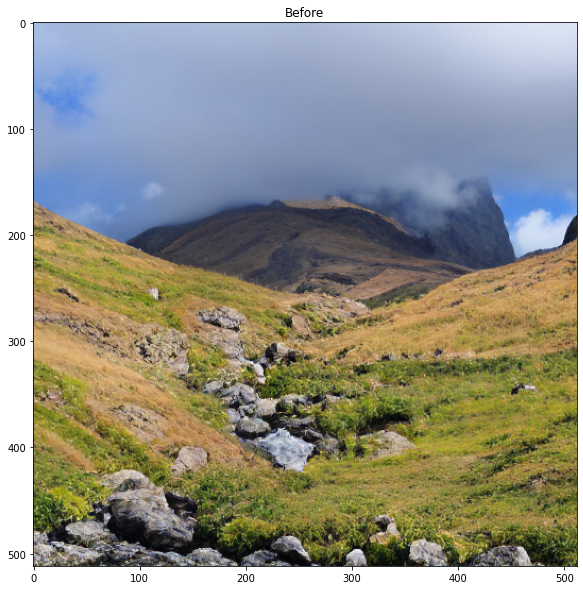

In [9]:
plt.figure(figsize = (10,10))
img = plt.imread("img/0.png")
plt.imshow(img)
plt.title("Before")

Text(0.5, 1.0, 'After')

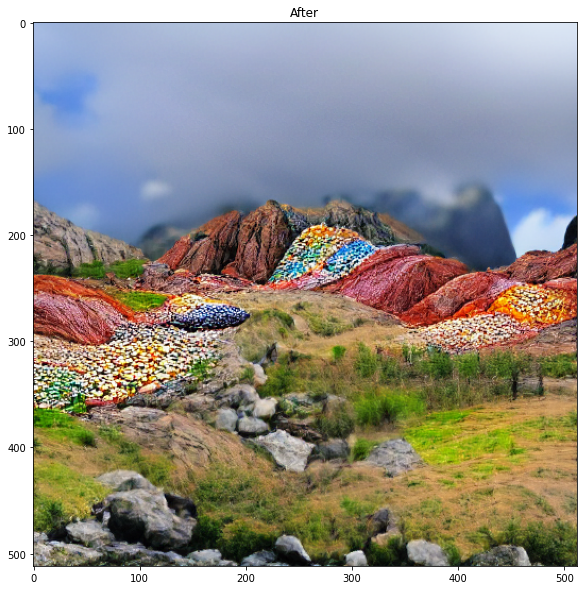

In [10]:
plt.figure(figsize = (10,10))
img = plt.imread(filepath)
plt.imshow(img)
plt.title("After")

In [11]:
objective.print_objective_loss_report()

╒═══════════════════════════════════════╤═══════════╤══════════════╤═════════════════════════╕
│ Prompt                                │ Exclude   │   Final loss │   Unweighted final loss │
╞═══════════════════════════════════════╪═══════════╪══════════════╪═════════════════════════╡
│ Landscape covered in colorfull rocks. │ False     │    -0.396729 │              -0.396729  │
├───────────────────────────────────────┼───────────┼──────────────┼─────────────────────────┤
│ Spatial control penality              │           │     0.157226 │               0.0157226 │
╘═══════════════════════════════════════╧═══════════╧══════════════╧═════════════════════════╛
